# Exploratory Analysis 3: homeoffice

Analogous to the main analysis, we will conduct seperate analyses for the subgroups
- a) all researchers, excluding those who commented positively on home office
- b) researchers who commented positively on home office

We identify the tweets commenting positively on home office through keyword-filtering, searching for the terms "home-office", "homeoffice", "home office" (pre-registered) and "working from home" (not preregistered). 

In [12]:
# activate virtual environment "masterenv"
import os
activate_this = os.path.join("/home/mueller/MA_researcher_wellbeing/masterenv", "bin", "activate_this.py")
exec(open(activate_this).read(), {'__file__': activate_this})

# import necessary packages
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sys
import re

## Prepare dfs

In [13]:
# load df
df_complete = pd.read_json("/home/mueller/MA_researcher_wellbeing/data/timelines_sentiments_nomiss.json", lines=True)
print(len(df_complete))
df_complete.head()

3488418


,user_id,created_at,text,is_reply,gender,neg_sent,neutr_sent,pos_sent
0,1079432684,2021-02-16 10:36:42,@NeuroBarbara @PuG2021online @svenpamann I am ...,True,female,0.007144,0.447894,0.544962
1,1079432684,2021-02-15 10:35:48,"So excited to start working with you, @impera_...",False,female,0.001824,0.007470,0.990707
2,1079432684,2021-02-15 10:11:53,We have launched a lab twitter account! For up...,False,female,0.003166,0.544907,0.451927
3,1079432684,2021-02-08 17:27:53,@RaschLab Preordered copy has already arrived!...,True,female,0.002222,0.007607,0.990171
4,1079432684,2021-02-02 22:23:36,@_rdgao I suggest Il Dolce! It’s a truly Itali...,True,female,0.026895,0.059307,0.913798


In [14]:
# categorize the sentiments
df_sents = df_complete[["neg_sent", "neutr_sent", "pos_sent"]]

def categorize_sent(row):
    max_sent = row.max()
    if max_sent == row["pos_sent"]:
        return 1
    if max_sent == row["neg_sent"]:
        return -1
    if max_sent == row["neutr_sent"]:
        return 0
    
df_complete["sent_cat"] = df_sents.apply(categorize_sent, axis = 1)

df_pos = df_complete[df_complete["sent_cat"] == 1]
df_pos = df_pos.drop("sent_cat", axis = 1)

# show df with positive sentiment texts
print(len(df_pos))
df_pos.head()

1561233


,user_id,created_at,text,is_reply,gender,neg_sent,neutr_sent,pos_sent
0,1079432684,2021-02-16 10:36:42,@NeuroBarbara @PuG2021online @svenpamann I am ...,True,female,0.007144,0.447894,0.544962
1,1079432684,2021-02-15 10:35:48,"So excited to start working with you, @impera_...",False,female,0.001824,0.007470,0.990707
3,1079432684,2021-02-08 17:27:53,@RaschLab Preordered copy has already arrived!...,True,female,0.002222,0.007607,0.990171
4,1079432684,2021-02-02 22:23:36,@_rdgao I suggest Il Dolce! It’s a truly Itali...,True,female,0.026895,0.059307,0.913798
5,1079432684,2021-01-26 18:49:35,@AnnaSchapiro @MichaelJArcaro Congratulations ...,True,female,0.004174,0.016029,0.979797


In [15]:
# filter for only tweets during the pandemic
pandemic_start = pd.to_datetime("2020-03-11")

df_pos_pandemic = df_pos[df_pos["created_at"] >= pandemic_start]
print(len(df_pos_pandemic))

967538


In [16]:
# keep only tweets that mention homeoffice keywords
keywords_homeoffice = ["home-office", "homeoffice", "home office", "working from home", "work from home", "#wfh"]
df_pos_ho = df_pos_pandemic[df_pos_pandemic["text"].str.contains('|'.join(keywords_homeoffice), case=False)]

# extract those user ids
df_pos_users = df_pos_ho["user_id"].unique()

print(len(df_pos_ho))
print(len(df_pos_users))

1658
1074


In [10]:
# check manually whether/which of the positive tweets containing a homeoffice keyword refer to "communicating a positive attitude towards home office"

# save complete df
df_pos_ho.to_csv("/home/mueller/MA_researcher_wellbeing/data/df_pos_ho.csv", index=False)

# save a random subsample to get a first impression
random_subsample = df_pos_ho.sample(n=100, random_state=42)
random_subsample.to_csv("/home/mueller/MA_researcher_wellbeing/data/df_pos_ho_subsample.csv", index=False)

Result: only 30 out of 100 (30%) tweets are really about a positive attitude towards homeoffice. Let's see what the analysis brings anyway!

---

In [22]:

### a) exclude those, who commented positively on home office
df_without_pos = df_complete[["user_id", "created_at", "pos_sent", "neg_sent"]]
df_without_pos = df_without_pos[~df_without_pos["user_id"].isin(df_pos_users)]

# weekly aggregation
df_without_pos = df_without_pos.drop("user_id", axis = 1)
n = df_without_pos.resample("W", on="created_at").size()
df_without_pos = df_without_pos.resample("W", on="created_at").mean()
df_without_pos["n"] = n
print(min(n))

## add T and X columns for ITS analysis
# week (T)
data_length = len(df_without_pos)
weeks = list(range(1, data_length + 1))
df_without_pos["week_T"] = weeks

# covid (X)
pandemic = [0]*52 + [1]*50
df_without_pos["pandemic_D"] = pandemic

df_without_pos.head()

4476


,pos_sent,neg_sent,n,week_T,pandemic_D
created_at,,,,,
2019-03-17,0.472958,0.172267,16132,1,0
2019-03-24,0.491613,0.159060,18113,2,0
2019-03-31,0.511828,0.157220,17050,3,0
2019-04-07,0.500617,0.154399,18461,4,0
2019-04-14,0.505865,0.155268,18455,5,0


In [23]:
### b) keep only those, who commented positively on home office
df_only_pos = df_complete[["user_id", "created_at", "pos_sent", "neg_sent"]]
df_only_pos = df_only_pos[df_only_pos["user_id"].isin(df_pos_users)]

# weekly aggregation
df_only_pos = df_only_pos.drop("user_id", axis = 1)
n = df_only_pos.resample("W", on="created_at").size()
df_only_pos = df_only_pos.resample("W", on="created_at").mean()
df_only_pos["n"] = n
print(min(n))

## add T and X columns for ITS analysis
# week (T)
df_only_pos["week_T"] = weeks

# covid (X)
df_only_pos["pandemic_D"] = pandemic

df_only_pos.head()

389


,pos_sent,neg_sent,n,week_T,pandemic_D
created_at,,,,,
2019-03-17,0.500365,0.149069,3229,1,0
2019-03-24,0.515054,0.143492,3484,2,0
2019-03-31,0.519669,0.141518,3318,3,0
2019-04-07,0.538114,0.140119,3573,4,0
2019-04-14,0.535701,0.138978,3420,5,0


## H1: POSITIVE SENTIMENTS

In [24]:
# define dfs
Y = df_without_pos["pos_sent"]
T = df_without_pos["week_T"]
D = df_without_pos["pandemic_D"]
df_nopos = pd.DataFrame({"Y": Y, "T": T, "D": D})

Y = df_only_pos["pos_sent"]
T = df_only_pos["week_T"]
D = df_only_pos["pandemic_D"]
df_onlypos = pd.DataFrame({"Y": Y, "T": T, "D": D})

### a) all researchers without those with positive attitude towards homeoffice

In [25]:
import pmdarima as pm

# fit the ARIMA model automatically
model = pm.auto_arima(df_nopos["Y"], seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-514.919, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-518.005, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-522.214, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-516.649, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-532.112, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-532.575, Time=0.06 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-519.219, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-529.310, Time=0.13 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-519.503, Time=0.02 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-513.555, Time=0.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-528.266, Time=0.11 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 0.978 seconds


In [26]:
from statsmodels.tsa.arima.model import ARIMA

# specify ARIMA model using the proposed parameters
arima_results_nopos = ARIMA(df_nopos["Y"], df_nopos[["T", "D"]], order=(2,1,1)).fit()
print(arima_results_nopos.summary(alpha=0.025))

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  102
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 274.062
Date:                Sat, 07 Oct 2023   AIC                           -536.124
Time:                        15:26:45   BIC                           -520.433
Sample:                    03-17-2019   HQIC                          -529.772
                         - 02-21-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|     [0.0125     0.9875]
------------------------------------------------------------------------------
T             -0.0006      0.001     -1.056      0.291      -0.002       0.001
D             -0.0375      0.011     -3.487      0.000      -0.062      -0.013
ar.L1          0.5009      0.113      4.431      0.0

/home/mueller/MA_researcher_wellbeing/masterenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Use bootstrapping to deal with the distribution of the data

In [ ]:
# Define the number of bootstrap samples
n_bootstrap_samples = 1000
coefficient_D_estimates = []

# Define the block size for block bootstrapping
block_size = 3  # how many segments of data are resampled together (I need a quite small block size to capture short-term variation (effect of the start of the pandemic))

# Perform block bootstrapping
for _ in range(n_bootstrap_samples):
    # Generate a bootstrap sample of 'Y' and 'D' using block bootstrapping
    bootstrap_indices = np.random.randint(1, len(df_nopos) - block_size, len(df_nopos) // block_size)
    bootstrap_indices = np.repeat(bootstrap_indices, block_size) + np.tile(np.arange(block_size), len(bootstrap_indices))
    bootstrap_sample = df_nopos.iloc[bootstrap_indices]

    # Fit ARIMA model to the bootstrap sample
    bootstrap_model = ARIMA(bootstrap_sample["Y"], bootstrap_sample[["T", "D"]], order=(2, 1, 1)).fit()

    # Store the estimated coefficient for 'D'
    coefficient_D_estimates.append(bootstrap_model.params["D"])

# Calculate standard errors and confidence intervals for the coefficient of 'D'
coefficient_D_estimates = np.array(coefficient_D_estimates)
coefficient_D_std_error = coefficient_D_estimates.std()
coefficient_D_ci_lower = np.percentile(coefficient_D_estimates, 1.25)
coefficient_D_ci_upper = np.percentile(coefficient_D_estimates, 98.75)

# Print the results
print("Bootstrap Standard Error for Coefficient of 'D':", coefficient_D_std_error)
print("Bootstrap 97.5% Confidence Interval for Coefficient of 'D':")
print("Lower Bound:", coefficient_D_ci_lower)
print("Upper Bound:", coefficient_D_ci_upper)

    Bootstrap Standard Error for Coefficient of 'D': 0.010704872989945026
    Bootstrap 97.5% Confidence Interval for Coefficient of 'D':
    Lower Bound: -0.050037956553163225
    Upper Bound: -0.0027586102326596766

Text(0, 0.5, 'Positive sentiments')

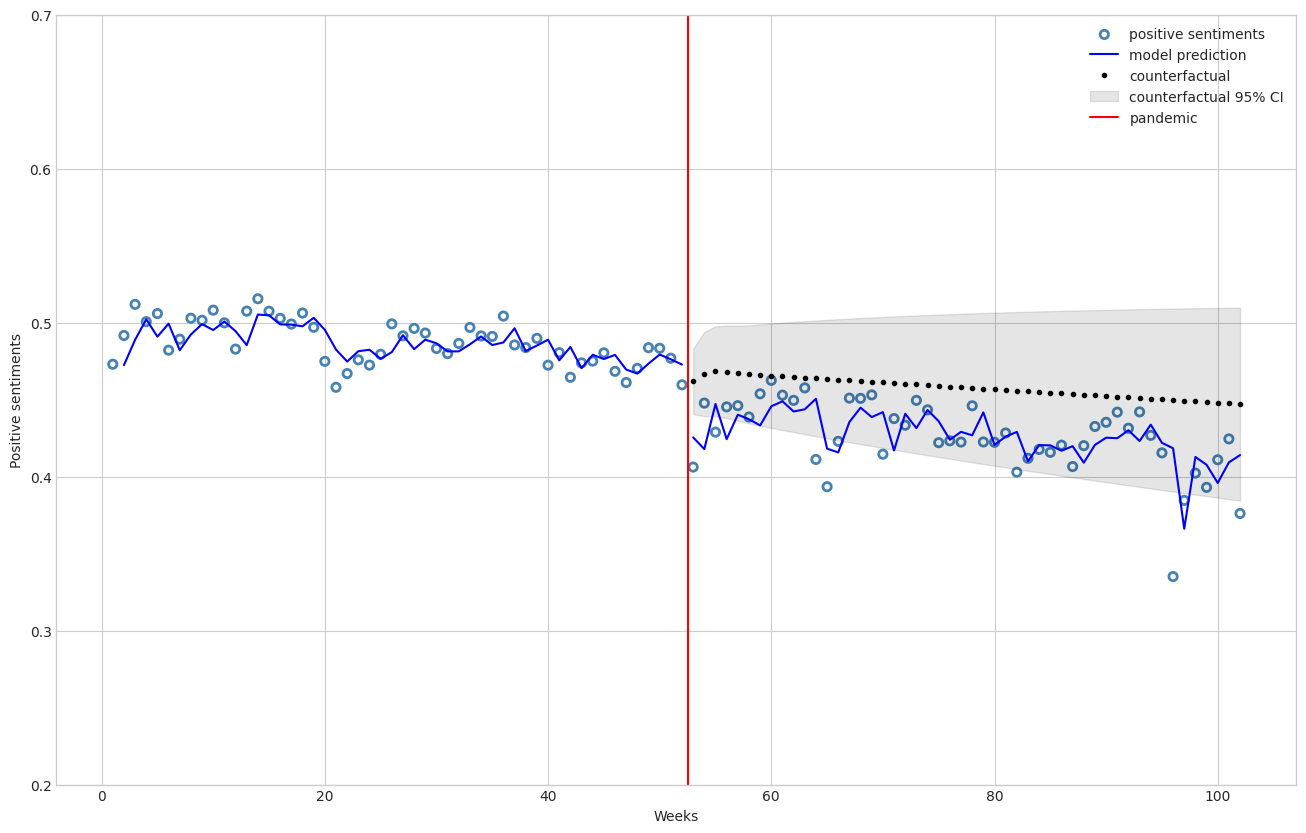

In [28]:
start = 52
end = 102

# get the model predictions for the whole time period (start till end)
predictions = arima_results_nopos.get_prediction(0, end-1)
summary = predictions.summary_frame(alpha=0.025)

# get the counterfactual ARIMA by fitting a model only for the first time period (before the pandemic)
arima_cf = ARIMA(df_nopos["Y"][:start], df_nopos["T"][:start], order=(2,1,1)).fit()

# model predictions means
y_pred = predictions.predicted_mean

# counterfactual mean and 95% confidence interval
y_cf = arima_cf.get_forecast(50, exog=df_nopos["T"][start:]).summary_frame(alpha=0.05)

# plot section
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16,10))

# plot weekly sentiment data
ax.scatter(df_nopos["T"], df_nopos["Y"], facecolors='none', edgecolors='steelblue', label="positive sentiments", linewidths=2)

# plot model mean sentiment prediction
ax.plot(df_nopos["T"][1:start], y_pred[1:start], 'b-', label="model prediction")
ax.plot(df_nopos["T"][start:], y_pred[start:], 'b-')

# plot counterfactual mean sentiment with 95% confidence interval
ax.plot(df_nopos["T"][start:], y_cf["mean"], 'k.', label="counterfactual")
ax.fill_between(df_nopos["T"][start:], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="counterfactual 95% CI")


# plot line marking the week of the official start of the pandemic (WHO)
ax.axvline(x = 52.5, color = 'r', label = 'pandemic')

ax.legend(loc='best')
plt.ylim([0.2, 0.7])
plt.xlabel("Weeks")
plt.ylabel("Positive sentiments")

### b) only researchers who commented positively on homeoffice

In [29]:
# fit the ARIMA model automatically
model = pm.auto_arima(df_onlypos["Y"], seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-506.466, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-513.419, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-516.491, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-508.398, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-521.390, Time=0.08 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-519.597, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-519.521, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-518.765, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-512.706, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-521.562, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-518.166, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-515.283, Time=0.03 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-519.724, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0]             : 

In [30]:
# specify ARIMA model using the proposed parameters
arima_results_onlypos = ARIMA(df_onlypos["Y"], df_onlypos[["T", "D"]], order=(1,1,1)).fit()
print(arima_results_onlypos.summary(alpha=0.025))

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  102
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 271.888
Date:                Sat, 07 Oct 2023   AIC                           -533.777
Time:                        15:32:52   BIC                           -520.701
Sample:                    03-17-2019   HQIC                          -528.483
                         - 02-21-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|     [0.0125     0.9875]
------------------------------------------------------------------------------
T             -0.0002      0.000     -0.749      0.454      -0.001       0.000
D             -0.0486      0.012     -3.946      0.000      -0.076      -0.021
ar.L1          0.4498      0.104      4.336      0.0

/home/mueller/MA_researcher_wellbeing/masterenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Define the number of bootstrap samples
n_bootstrap_samples = 1000
coefficient_D_estimates = []

# Define the block size for block bootstrapping
block_size = 3  # how many segments of data are resampled together (I need a quite small block size to capture short-term variation (effect of the start of the pandemic))

# Perform block bootstrapping
for _ in range(n_bootstrap_samples):
    # Generate a bootstrap sample of 'Y' and 'D' using block bootstrapping
    bootstrap_indices = np.random.randint(1, len(df_onlypos) - block_size, len(df_onlypos) // block_size)
    bootstrap_indices = np.repeat(bootstrap_indices, block_size) + np.tile(np.arange(block_size), len(bootstrap_indices))
    bootstrap_sample = df_onlypos.iloc[bootstrap_indices]

    # Fit ARIMA model to the bootstrap sample
    bootstrap_model = ARIMA(bootstrap_sample["Y"], bootstrap_sample[["T", "D"]], order=(1, 1, 1)).fit()

    # Store the estimated coefficient for 'D'
    coefficient_D_estimates.append(bootstrap_model.params["D"])

# Calculate standard errors and confidence intervals for the coefficient of 'D'
coefficient_D_estimates = np.array(coefficient_D_estimates)
coefficient_D_std_error = coefficient_D_estimates.std()
coefficient_D_ci_lower = np.percentile(coefficient_D_estimates, 1.25)
coefficient_D_ci_upper = np.percentile(coefficient_D_estimates, 98.75)

# Print the results
print("Bootstrap Standard Error for Coefficient of 'D':", coefficient_D_std_error)
print("Bootstrap 97.5% Confidence Interval for Coefficient of 'D':")
print("Lower Bound:", coefficient_D_ci_lower)
print("Upper Bound:", coefficient_D_ci_upper)

    Bootstrap Standard Error for Coefficient of 'D': 0.010941326007937518
    Bootstrap 97.5% Confidence Interval for Coefficient of 'D':
    Lower Bound: -0.07768930313213712
    Upper Bound: -0.022639324256518874

Text(0, 0.5, 'Positive sentiments')

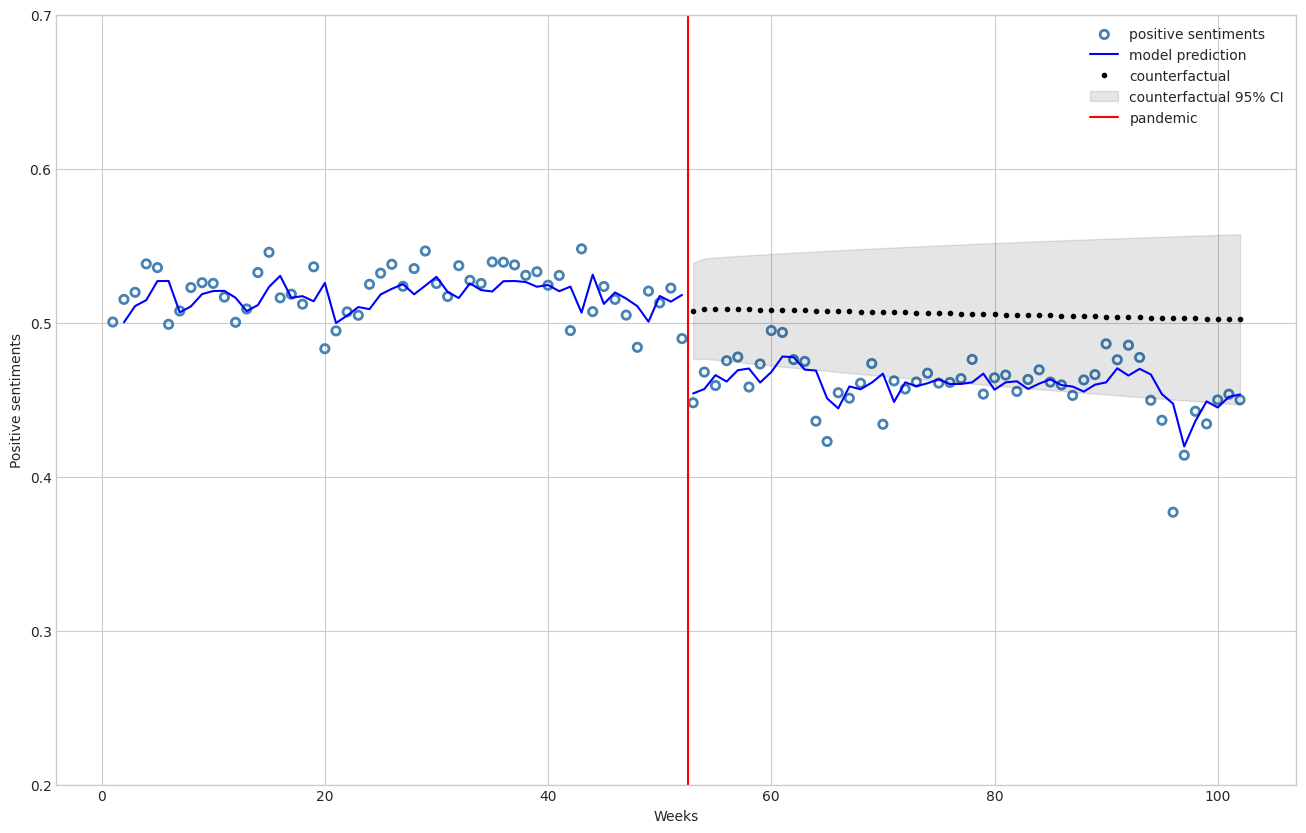

In [32]:
start = 52
end = 102

# get the model predictions for the whole time period (start till end)
predictions = arima_results_onlypos.get_prediction(0, end-1)
summary = predictions.summary_frame(alpha=0.025)

# get the counterfactual ARIMA by fitting a model only for the first time period (before the pandemic)
arima_cf = ARIMA(df_onlypos["Y"][:start], df_onlypos["T"][:start], order=(1,1,1)).fit()

# model predictions means
y_pred = predictions.predicted_mean

# counterfactual mean and 95% confidence interval
y_cf = arima_cf.get_forecast(50, exog=df_onlypos["T"][start:]).summary_frame(alpha=0.05)

# plot section
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16,10))

# plot weekly sentiment data
ax.scatter(df_onlypos["T"], df_onlypos["Y"], facecolors='none', edgecolors='steelblue', label="positive sentiments", linewidths=2)

# plot model mean sentiment prediction
ax.plot(df_onlypos["T"][1:start], y_pred[1:start], 'b-', label="model prediction")
ax.plot(df_onlypos["T"][start:], y_pred[start:], 'b-')

# plot counterfactual mean sentiment with 95% confidence interval
ax.plot(df_onlypos["T"][start:], y_cf["mean"], 'k.', label="counterfactual")
ax.fill_between(df_onlypos["T"][start:], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="counterfactual 95% CI")


# plot line marking the week of the official start of the pandemic (WHO)
ax.axvline(x = 52.5, color = 'r', label = 'pandemic')

ax.legend(loc='best')
plt.ylim([0.2, 0.7])
plt.xlabel("Weeks")
plt.ylabel("Positive sentiments")

### plot them together

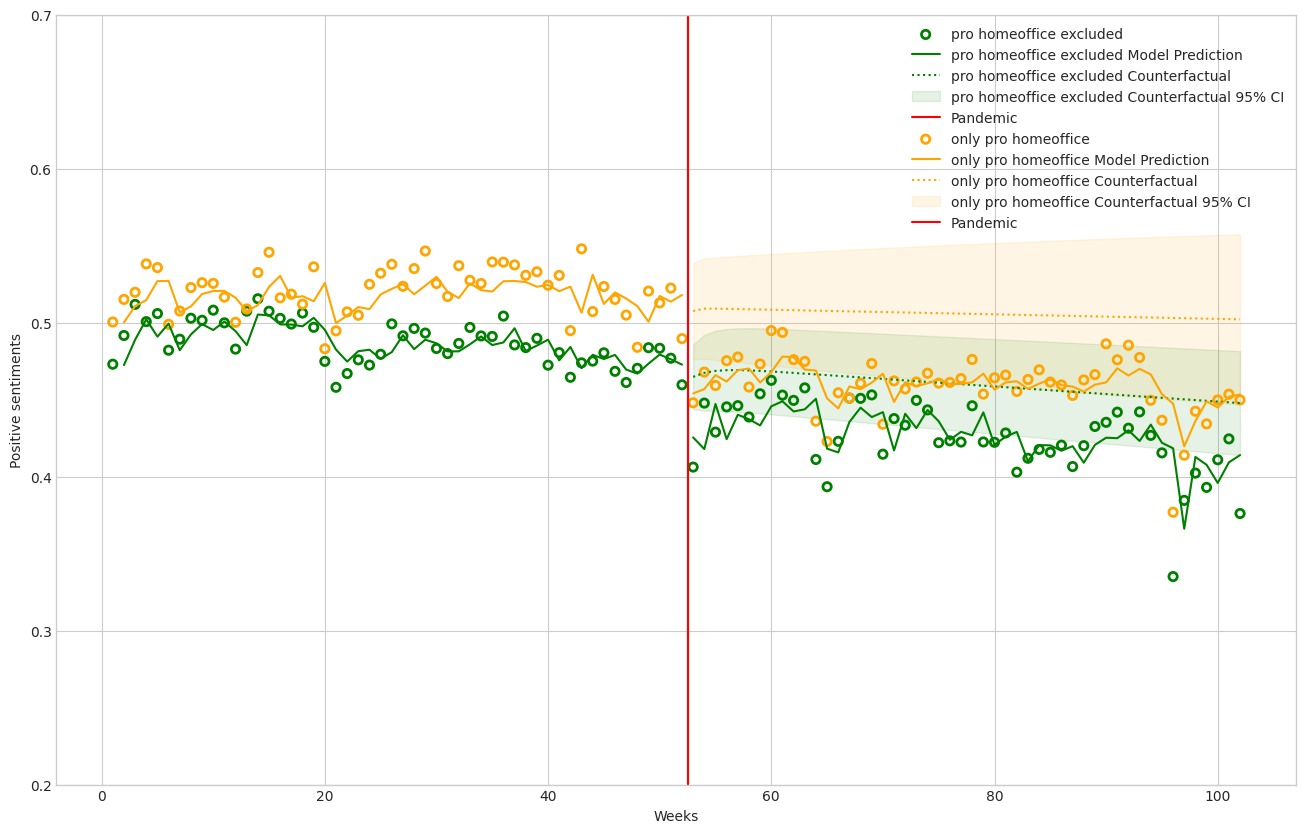

In [34]:
# Define a function to generate the ARIMA plots
def generate_arima_plot(ax, df, arima_results, color, label):
    start = 52
    end = 102

    # get the model predictions for the whole time period (start till end)
    predictions = arima_results.get_prediction(0, end-1)

    # get the counterfactual ARIMA by fitting a model only for the first time period (before the pandemic)
    arima_cf = ARIMA(df["Y"][:start], df["T"][:start], order=(1,1,1)).fit()

    # model predictions means
    y_pred = predictions.predicted_mean

    # counterfactual mean and 95% confidence interval
    y_cf = arima_cf.get_forecast(50, exog=df["T"][start:]).summary_frame(alpha=0.05)

    # plot weekly sentiment data
    ax.scatter(df["T"], df["Y"], facecolors='none', edgecolors=color, label=label, linewidths=2)

    # plot model mean sentiment prediction
    ax.plot(df["T"][1:start], y_pred[1:start], color=color, linestyle='-', label=f"{label} Model Prediction")
    ax.plot(df["T"][start:], y_pred[start:], color=color, linestyle='-')

    # plot counterfactual mean sentiment with 95% confidence interval
    ax.plot(df["T"][start:], y_cf["mean"], color=color, linestyle='dotted', label=f"{label} Counterfactual")
    ax.fill_between(df["T"][start:], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color=color, alpha=0.1, label=f"{label} Counterfactual 95% CI")

    # plot line marking the week of the official start of the pandemic (WHO)
    ax.axvline(x=52.5, color='r', label='Pandemic')

    ax.set_ylim([0.2, 0.7])
    ax.set_xlabel("Weeks")
    ax.set_ylabel("Positive sentiments")
    ax.legend(loc='best')

# Create a single plot
fig, ax = plt.subplots(figsize=(16, 10))

# Generate the first plot (female data) in green
generate_arima_plot(ax, df_nopos, arima_results_nopos, color='green', label='pro homeoffice excluded')

# Generate the second plot (male data) in orange
generate_arima_plot(ax, df_onlypos, arima_results_onlypos, color='orange', label='only pro homeoffice')

# Show the combined plot
plt.show()


## H1: NEGATIVE SENTIMENTS

In [35]:
# define dfs
Y = df_without_pos["neg_sent"]
T = df_without_pos["week_T"]
D = df_without_pos["pandemic_D"]
df_nopos = pd.DataFrame({"Y": Y, "T": T, "D": D})

Y = df_only_pos["neg_sent"]
T = df_only_pos["week_T"]
D = df_only_pos["pandemic_D"]
df_onlypos = pd.DataFrame({"Y": Y, "T": T, "D": D})

### a) all researchers without those with positive attitude towards homeoffice

In [36]:
# fit the ARIMA model automatically
model = pm.auto_arima(df_nopos["Y"], seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-573.214, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-574.657, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-578.077, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-574.765, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-586.642, Time=0.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-592.340, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-576.788, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-588.408, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-591.982, Time=0.11 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-576.416, Time=0.06 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-587.162, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-585.181, Time=0.06 sec

Best model:  ARIMA(2,1,1)(0,0,0)[0] intercept
Total fit time: 1.119 seconds


In [37]:
# specify ARIMA model using the proposed parameters
arima_results_nopos = ARIMA(df_nopos["Y"], df_nopos[["T", "D"]], order=(2,1,1)).fit()
print(arima_results_nopos.summary(alpha=0.025))

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  102
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 302.777
Date:                Sat, 07 Oct 2023   AIC                           -593.554
Time:                        15:59:33   BIC                           -577.863
Sample:                    03-17-2019   HQIC                          -587.201
                         - 02-21-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|     [0.0125     0.9875]
------------------------------------------------------------------------------
T              0.0007      0.000      2.481      0.013    6.87e-05       0.001
D              0.0118      0.009      1.340      0.180      -0.008       0.032
ar.L1          0.4890      0.105      4.668      0.0

/home/mueller/MA_researcher_wellbeing/masterenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [ ]:
# Define the number of bootstrap samples
n_bootstrap_samples = 1000
coefficient_D_estimates = []

# Define the block size for block bootstrapping
block_size = 3  # how many segments of data are resampled together (I need a quite small block size to capture short-term variation (effect of the start of the pandemic))

# Perform block bootstrapping
for _ in range(n_bootstrap_samples):
    # Generate a bootstrap sample of 'Y' and 'D' using block bootstrapping
    bootstrap_indices = np.random.randint(1, len(df_nopos) - block_size, len(df_nopos) // block_size)
    bootstrap_indices = np.repeat(bootstrap_indices, block_size) + np.tile(np.arange(block_size), len(bootstrap_indices))
    bootstrap_sample = df_nopos.iloc[bootstrap_indices]

    # Fit ARIMA model to the bootstrap sample
    bootstrap_model = ARIMA(bootstrap_sample["Y"], bootstrap_sample[["T", "D"]], order=(2, 1, 1)).fit()

    # Store the estimated coefficient for 'D'
    coefficient_D_estimates.append(bootstrap_model.params["D"])

# Calculate standard errors and confidence intervals for the coefficient of 'D'
coefficient_D_estimates = np.array(coefficient_D_estimates)
coefficient_D_std_error = coefficient_D_estimates.std()
coefficient_D_ci_lower = np.percentile(coefficient_D_estimates, 1.25)
coefficient_D_ci_upper = np.percentile(coefficient_D_estimates, 98.75)

# Print the results
print("Bootstrap Standard Error for Coefficient of 'D':", coefficient_D_std_error)
print("Bootstrap 97.5% Confidence Interval for Coefficient of 'D':")
print("Lower Bound:", coefficient_D_ci_lower)
print("Upper Bound:", coefficient_D_ci_upper)

    Bootstrap Standard Error for Coefficient of 'D': 0.008135928878986582
    Bootstrap 97.5% Confidence Interval for Coefficient of 'D':
    Lower Bound: -0.006034089544624022
    Upper Bound: 0.030520606658501398

Text(0, 0.5, 'Negative sentiments')

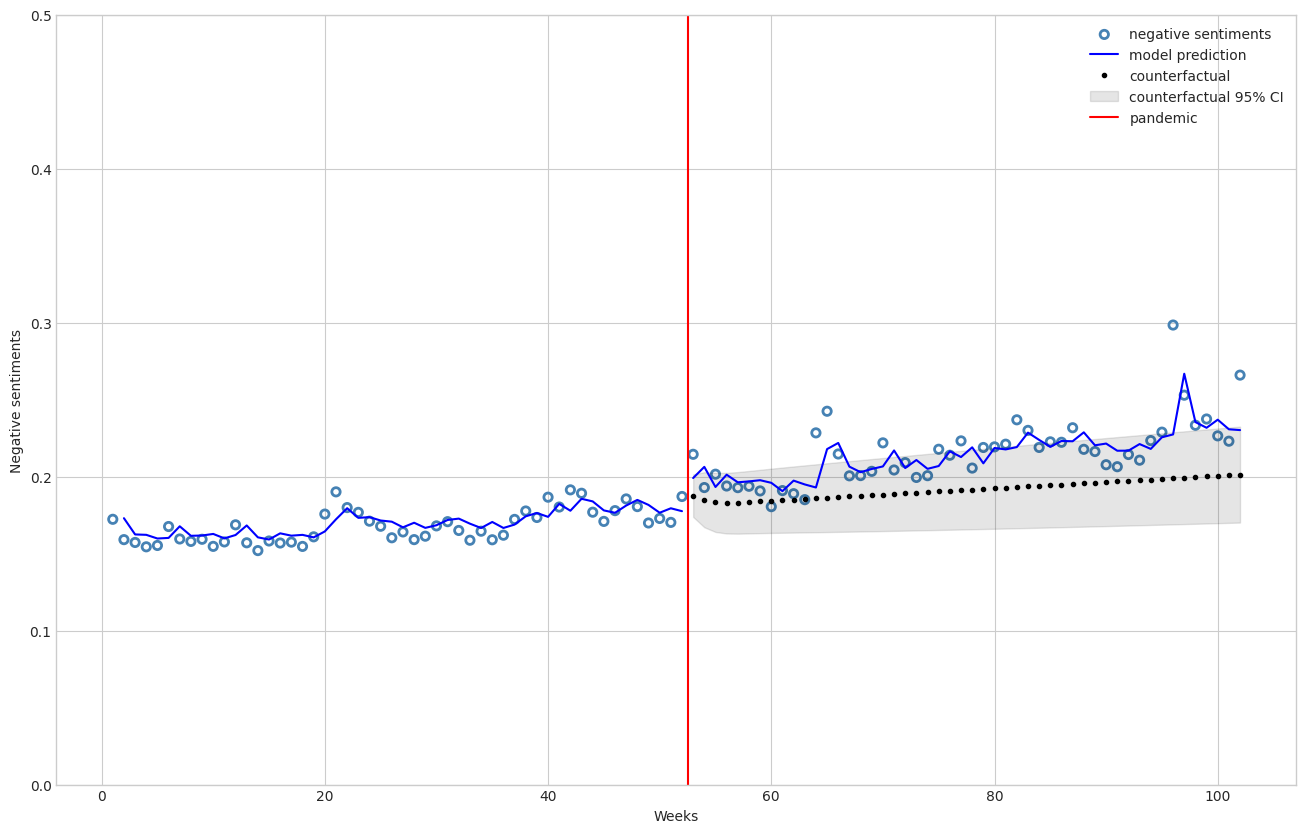

In [39]:
start = 52
end = 102

# get the model predictions for the whole time period (start till end)
predictions = arima_results_nopos.get_prediction(0, end-1)
summary = predictions.summary_frame(alpha=0.025)

# get the counterfactual ARIMA by fitting a model only for the first time period (before the pandemic)
arima_cf = ARIMA(df_nopos["Y"][:start], df_nopos["T"][:start], order=(2,1,1)).fit()

# model predictions means
y_pred = predictions.predicted_mean

# counterfactual mean and 95% confidence interval
y_cf = arima_cf.get_forecast(50, exog=df_nopos["T"][start:]).summary_frame(alpha=0.05)

# plot section
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16,10))

# plot weekly sentiment data
ax.scatter(df_nopos["T"], df_nopos["Y"], facecolors='none', edgecolors='steelblue', label="negative sentiments", linewidths=2)

# plot model mean sentiment prediction
ax.plot(df_nopos["T"][1:start], y_pred[1:start], 'b-', label="model prediction")
ax.plot(df_nopos["T"][start:], y_pred[start:], 'b-')

# plot counterfactual mean sentiment with 95% confidence interval
ax.plot(df_nopos["T"][start:], y_cf["mean"], 'k.', label="counterfactual")
ax.fill_between(df_nopos["T"][start:], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="counterfactual 95% CI")


# plot line marking the week of the official start of the pandemic (WHO)
ax.axvline(x = 52.5, color = 'r', label = 'pandemic')

ax.legend(loc='best')
plt.ylim([0, 0.5])
plt.xlabel("Weeks")
plt.ylabel("Negative sentiments")

### b) only researchers who commented positively on homeoffice

In [40]:
# fit the ARIMA model automatically
model = pm.auto_arima(df_onlypos["Y"], seasonal=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-583.784, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-567.062, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-578.297, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-579.010, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-568.957, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-575.689, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-583.477, Time=0.11 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-582.168, Time=0.15 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-582.337, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-576.382, Time=0.04 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-585.072, Time=0.04 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-585.024, Time=0.08 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-581.597, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-578.617, Time=0.09 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept

In [41]:
# specify ARIMA model using the proposed parameters
arima_results_onlypos = ARIMA(df_onlypos["Y"], df_onlypos[["T", "D"]], order=(0,1,4)).fit()
print(arima_results_onlypos.summary(alpha=0.025))

                               SARIMAX Results                                
Dep. Variable:                      Y   No. Observations:                  102
Model:                 ARIMA(0, 1, 4)   Log Likelihood                 301.394
Date:                Sat, 07 Oct 2023   AIC                           -588.788
Time:                        16:03:01   BIC                           -570.482
Sample:                    03-17-2019   HQIC                          -581.377
                         - 02-21-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|     [0.0125     0.9875]
------------------------------------------------------------------------------
T              0.0005      0.000      2.000      0.046   -6.46e-05       0.001
D              0.0213      0.014      1.549      0.121      -0.010       0.052
ma.L1         -0.4773      0.116     -4.120      0.0

In [ ]:
# Define the number of bootstrap samples
n_bootstrap_samples = 1000
coefficient_D_estimates = []

# Define the block size for block bootstrapping
block_size = 3  # how many segments of data are resampled together (I need a quite small block size to capture short-term variation (effect of the start of the pandemic))

# Perform block bootstrapping
for _ in range(n_bootstrap_samples):
    # Generate a bootstrap sample of 'Y' and 'D' using block bootstrapping
    bootstrap_indices = np.random.randint(1, len(df_onlypos) - block_size, len(df_onlypos) // block_size)
    bootstrap_indices = np.repeat(bootstrap_indices, block_size) + np.tile(np.arange(block_size), len(bootstrap_indices))
    bootstrap_sample = df_onlypos.iloc[bootstrap_indices]

    # Fit ARIMA model to the bootstrap sample
    bootstrap_model = ARIMA(bootstrap_sample["Y"], bootstrap_sample[["T", "D"]], order=(0, 1, 4)).fit()

    # Store the estimated coefficient for 'D'
    coefficient_D_estimates.append(bootstrap_model.params["D"])

# Calculate standard errors and confidence intervals for the coefficient of 'D'
coefficient_D_estimates = np.array(coefficient_D_estimates)
coefficient_D_std_error = coefficient_D_estimates.std()
coefficient_D_ci_lower = np.percentile(coefficient_D_estimates, 1.25)
coefficient_D_ci_upper = np.percentile(coefficient_D_estimates, 98.75)

# Print the results
print("Bootstrap Standard Error for Coefficient of 'D':", coefficient_D_std_error)
print("Bootstrap 97.5% Confidence Interval for Coefficient of 'D':")
print("Lower Bound:", coefficient_D_ci_lower)
print("Upper Bound:", coefficient_D_ci_upper)

    Bootstrap Standard Error for Coefficient of 'D': 0.008423313666249556
    Bootstrap 97.5% Confidence Interval for Coefficient of 'D':
    Lower Bound: 0.0018878945978403696
    Upper Bound: 0.041169271053301267

/home/mueller/MA_researcher_wellbeing/masterenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0, 0.5, 'Negative sentiments')

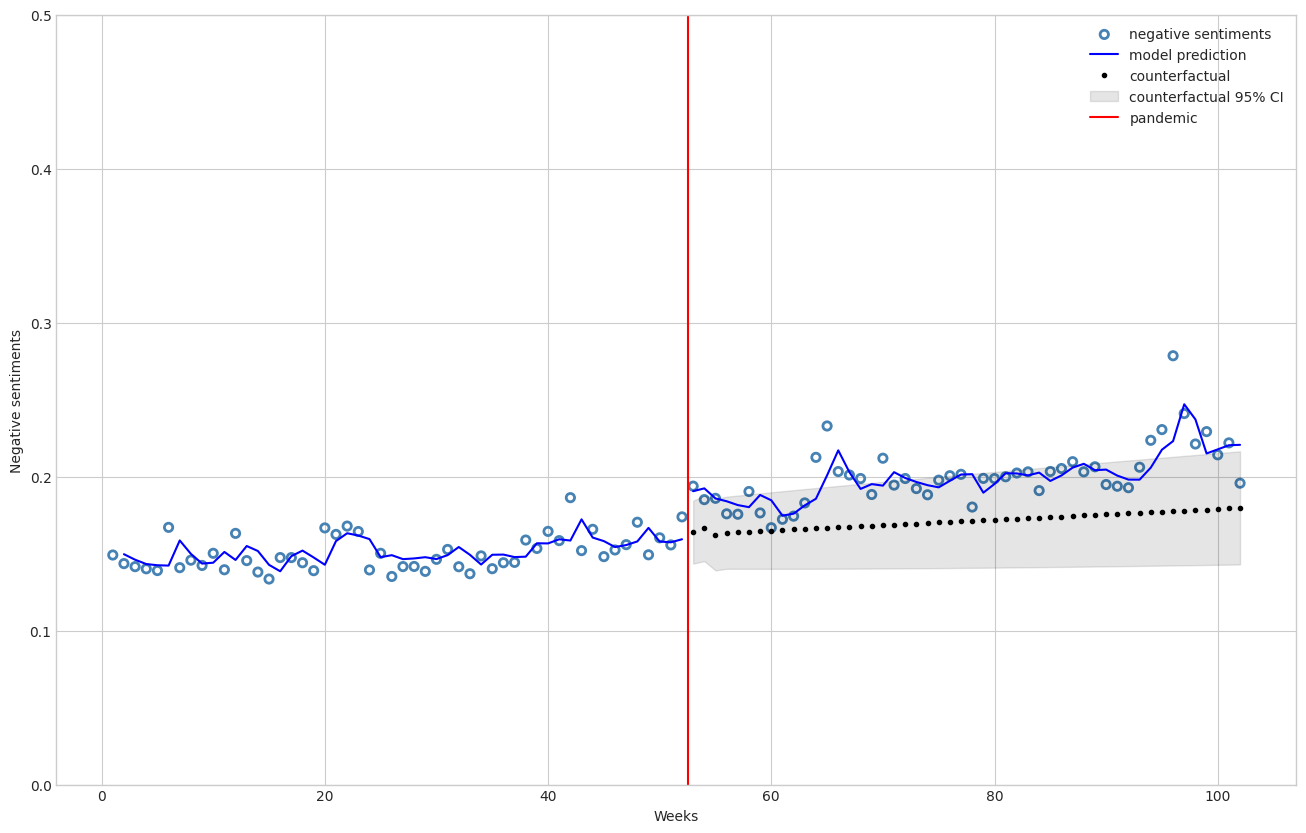

In [43]:
start = 52
end = 102

# get the model predictions for the whole time period (start till end)
predictions = arima_results_onlypos.get_prediction(0, end-1)
summary = predictions.summary_frame(alpha=0.025)

# get the counterfactual ARIMA by fitting a model only for the first time period (before the pandemic)
arima_cf = ARIMA(df_onlypos["Y"][:start], df_onlypos["T"][:start], order=(0,1,4)).fit()

# model predictions means
y_pred = predictions.predicted_mean

# counterfactual mean and 95% confidence interval
y_cf = arima_cf.get_forecast(50, exog=df_onlypos["T"][start:]).summary_frame(alpha=0.05)

# plot section
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(16,10))

# plot weekly sentiment data
ax.scatter(df_onlypos["T"], df_onlypos["Y"], facecolors='none', edgecolors='steelblue', label="negative sentiments", linewidths=2)

# plot model mean sentiment prediction
ax.plot(df_onlypos["T"][1:start], y_pred[1:start], 'b-', label="model prediction")
ax.plot(df_onlypos["T"][start:], y_pred[start:], 'b-')

# plot counterfactual mean sentiment with 95% confidence interval
ax.plot(df_onlypos["T"][start:], y_cf["mean"], 'k.', label="counterfactual")
ax.fill_between(df_onlypos["T"][start:], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color='k', alpha=0.1, label="counterfactual 95% CI")


# plot line marking the week of the official start of the pandemic (WHO)
ax.axvline(x = 52.5, color = 'r', label = 'pandemic')

ax.legend(loc='best')
plt.ylim([0, 0.5])
plt.xlabel("Weeks")
plt.ylabel("Negative sentiments")

### plot them together

/home/mueller/MA_researcher_wellbeing/masterenv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/mueller/MA_researcher_wellbeing/masterenv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


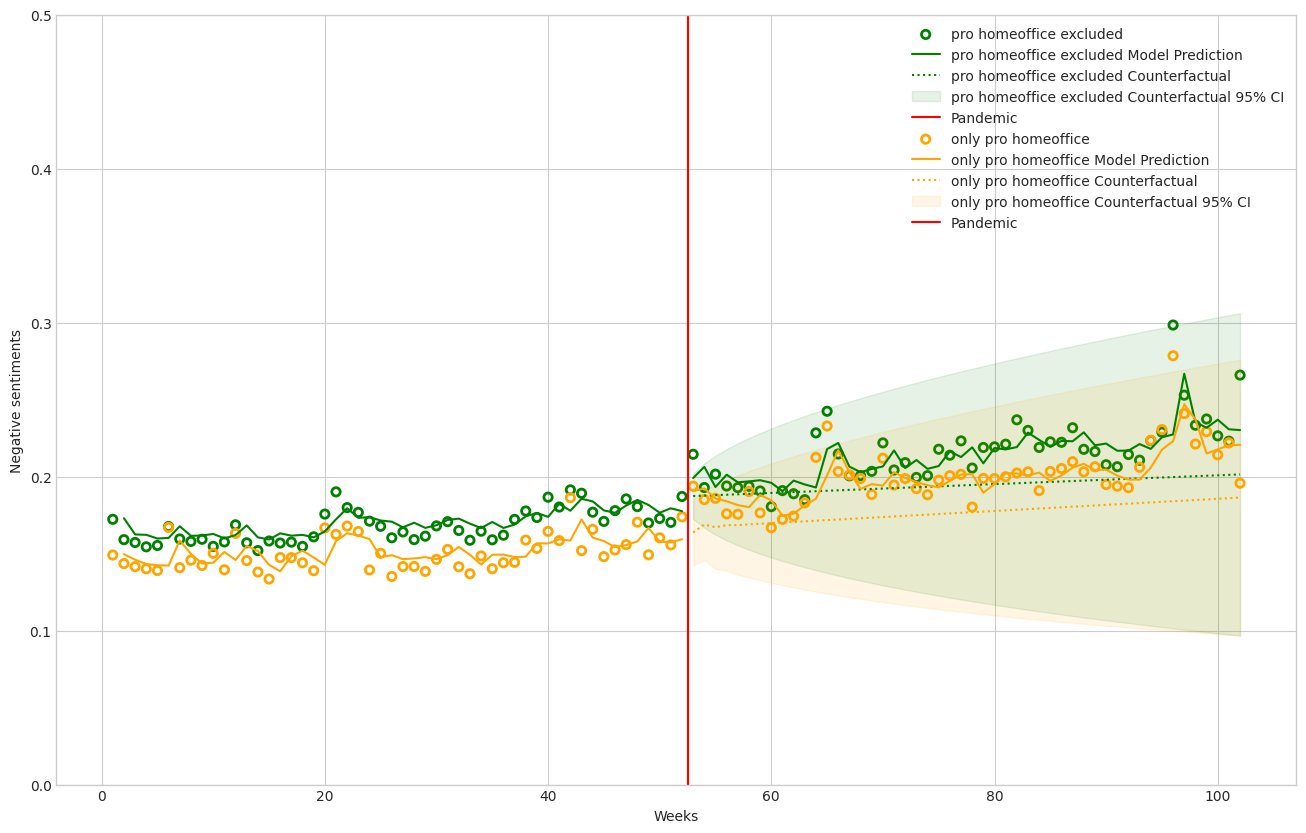

In [44]:
# Define a function to generate the ARIMA plots
def generate_arima_plot(ax, df, arima_results, color, label):
    start = 52
    end = 102

    # get the model predictions for the whole time period (start till end)
    predictions = arima_results.get_prediction(0, end-1)

    # get the counterfactual ARIMA by fitting a model only for the first time period (before the pandemic)
    arima_cf = ARIMA(df["Y"][:start], df["T"][:start], order=(1,1,1)).fit()

    # model predictions means
    y_pred = predictions.predicted_mean

    # counterfactual mean and 95% confidence interval
    y_cf = arima_cf.get_forecast(50, exog=df["T"][start:]).summary_frame(alpha=0.05)

    # plot weekly sentiment data
    ax.scatter(df["T"], df["Y"], facecolors='none', edgecolors=color, label=label, linewidths=2)

    # plot model mean sentiment prediction
    ax.plot(df["T"][1:start], y_pred[1:start], color=color, linestyle='-', label=f"{label} Model Prediction")
    ax.plot(df["T"][start:], y_pred[start:], color=color, linestyle='-')

    # plot counterfactual mean sentiment with 95% confidence interval
    ax.plot(df["T"][start:], y_cf["mean"], color=color, linestyle='dotted', label=f"{label} Counterfactual")
    ax.fill_between(df["T"][start:], y_cf['mean_ci_lower'], y_cf['mean_ci_upper'], color=color, alpha=0.1, label=f"{label} Counterfactual 95% CI")

    # plot line marking the week of the official start of the pandemic (WHO)
    ax.axvline(x=52.5, color='r', label='Pandemic')

    ax.set_ylim([0, 0.5])
    ax.set_xlabel("Weeks")
    ax.set_ylabel("Negative sentiments")
    ax.legend(loc='best')

# Create a single plot
fig, ax = plt.subplots(figsize=(16, 10))

# Generate the first plot (female data) in green
generate_arima_plot(ax, df_nopos, arima_results_nopos, color='green', label='pro homeoffice excluded')

# Generate the second plot (male data) in orange
generate_arima_plot(ax, df_onlypos, arima_results_onlypos, color='orange', label='only pro homeoffice')

# Show the combined plot
plt.show()
